# Part II - Effects of user types, member gender and day on duration of bike sharing
## by Egbebuike Emmanuel

## Investigation Overview

In this investigation, I explored the effects of some variables on the length of the bike sharing. Of particular interest were te user type (customer or subscriber) and then the day of the week. THe effect of the gender on duration would be shown.


## Dataset Overview
The dataset consists of about 184,000. To use this data, I had to clean up the dataset. This involved changing column data types and extracting the day and day hour from the dataset. I dropped rows having null values and i removes the gps data of the start and end locations. This reduced the rows to about 175,000. Further into the analysis, I used the log of the duration_sec to provide better analysis and visualization.

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

#### Data cleanup and formatting

In [2]:
# load in the dataset into a pandas dataframe
dataset = pd.read_csv("201902-fordgobike-tripdata.csv")

#Preliminary wrangling
#remove the rows with nulls
dataset = dataset.dropna()

#change the time to date time
dataset.start_time = dataset.start_time.astype("datetime64[ns]")
dataset.end_time = dataset.end_time.astype("datetime64[ns]")

#change member birth year and the stations id to int
dataset.member_birth_year = dataset.member_birth_year.astype("int")
dataset.start_station_id = dataset.start_station_id.astype("int")
dataset.end_station_id = dataset.end_station_id.astype("int")

#extract the day and hour from the time
dataset["start_day"] = dataset.start_time.apply(lambda x: x.strftime("%a"))
dataset["start_hour"] = dataset.start_time.apply(lambda x: int(x.strftime("%H")))

dataset["end_day"] = dataset.end_time.apply(lambda x: x.strftime("%a"))
dataset["end_hour"] = dataset.end_time.apply(lambda x: int(x.strftime("%H")))
dataset.drop(["start_station_latitude", "start_station_longitude", "end_station_latitude", "end_station_longitude"], axis = 1, inplace = True)

#add a log of the duration
dataset["duration_log"] = np.log10(dataset["duration_sec"])

# convert start_day, end_day to ordinal
ordinal_var_dict = {'start_day': ['Mon', "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"],
                    'end_day': ['Mon', "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]}

for var in ordinal_var_dict:
    ordered_var = pd.api.types.CategoricalDtype(ordered = True, categories = ordinal_var_dict[var])
    dataset[var] = dataset[var].astype(ordered_var)
    


## Distribution of the duration

The duration(seconds) has most of the datapoints (over 97%)  below the 2000 sec mark. It has a unimodal distribution when plotted on a log scale. The mode is around 500 seconds.


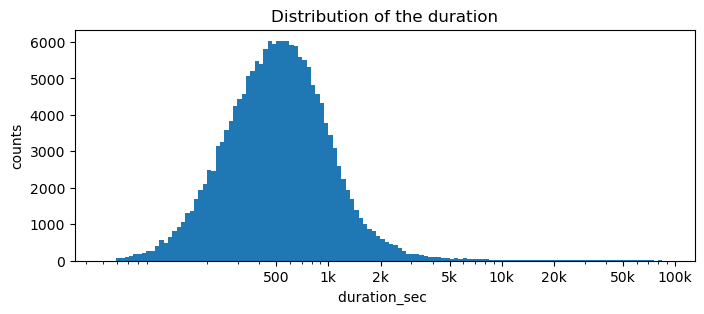

In [3]:
log_binsize = 0.025
bins = 10 ** np.arange(1.7, np.log10(dataset['duration_sec'].max())+log_binsize, log_binsize)
plt.figure(figsize=[8, 3])
plt.hist(data = dataset, x = 'duration_sec', bins = bins)
plt.xscale('log')
plt.xticks([500, 1e3, 2e3, 5e3, 1e4, 2e4, 5e4, 1e5], [500, '1k', '2k', '5k', '10k', '20k', "50k", "100k"])
plt.title("Distribution of the duration")
plt.ylabel("counts")
plt.xlabel('duration_sec ')
plt.show()


## Distribution and mean duration of customers and subscribers
We can see that the subscribers far outnumbers the customers. Furthermore, there are no customers who use the bike share for all trips. While the subscribers are more than the customers, the average duration of customers far exceeds that of subscribers.

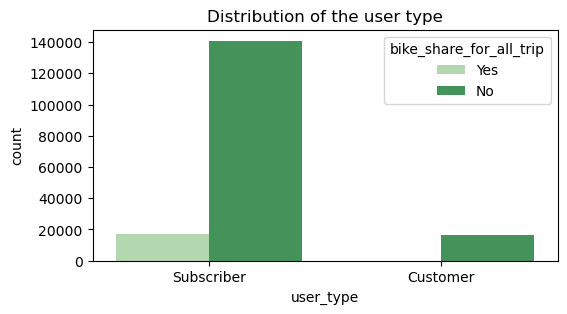

In [4]:
#remove outliers
dataset = dataset[dataset.duration_sec < 10000]
dataset = dataset[dataset.member_birth_year > 1900]


plt.figure(figsize=[6, 3])
plt.title("Distribution of the user type")
sb.countplot(data = dataset, x = 'user_type', hue = 'bike_share_for_all_trip', palette = 'Greens');

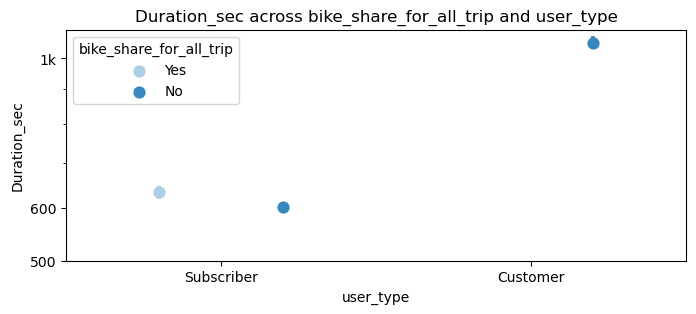

In [5]:
fig = plt.figure(figsize = [8,3])
ax = sb.pointplot(data = dataset, x = 'user_type', y = 'duration_sec', hue = 'bike_share_for_all_trip',
           palette = 'Blues', linestyles = '', dodge = 0.4)
plt.title('Duration_sec across bike_share_for_all_trip and user_type')
plt.ylabel('Duration_sec')
plt.yscale('log')
plt.yticks([500, 600, 1e3], [ "500", "600", '1k'])
ax.set_yticklabels([],minor = True)
plt.show();

## Duration variance across the day of the week
We see thar the weekends, while technically having the least number of bikeshare, boasts of days with the longest durations. In the second plot, you will see how sat and sun tapers off into the higher duration range. You would also see that the weekends is mostly active in the day, having a mono modal distribution, unlike the weekdays.


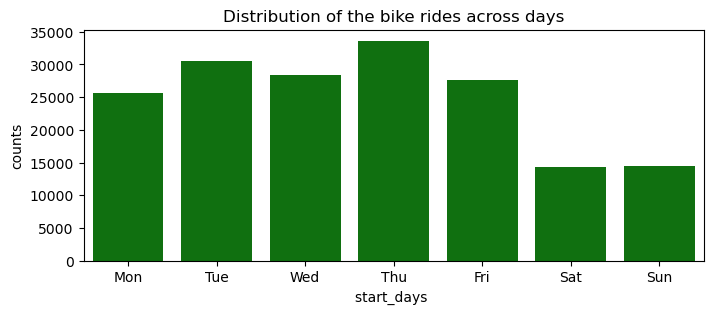

In [6]:
plt.figure(figsize=[8, 3])
# plt.hist(data = dataset, x = 'start_day')
sb.countplot(data = dataset, x = 'start_day',  color = 'green');
plt.title("Distribution of the bike rides across days")
plt.ylabel("counts")
plt.xlabel('start_days ')
plt.show()

In [7]:
# compute the logarithm of duration to make multivariate plotting easier
def log_trans(x, inverse = False):
    """ quick function for computing log and power operations """
    if not inverse:
        return np.log10(x)
    else:
        return np.power(10, x)

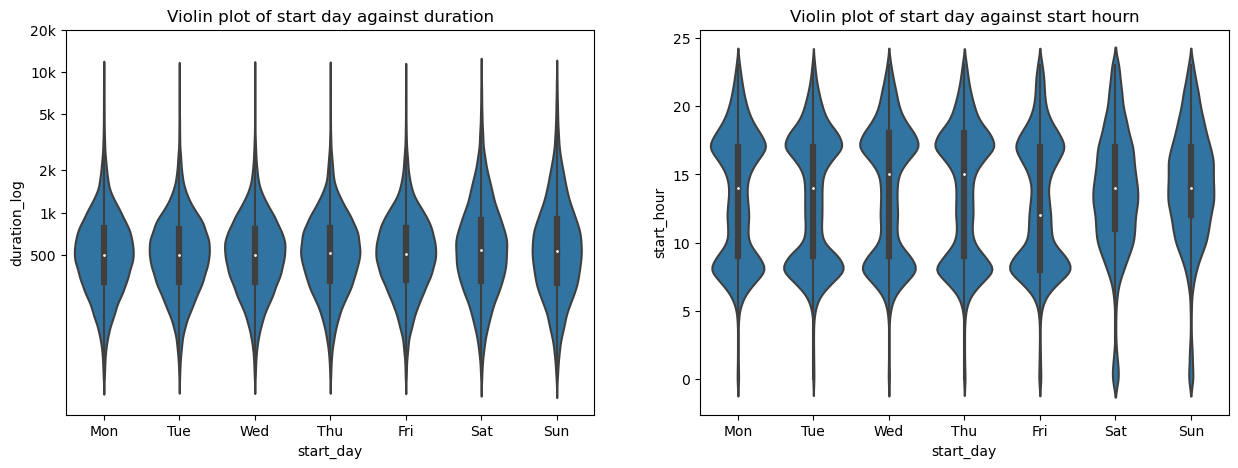

In [8]:
# start day against durarion and start hour
fig, ax = plt.subplots(ncols = 2, figsize = [15,5])
default_color = sb.color_palette()[0]
var = "start_day"
sb.violinplot(data = dataset, x = var, y = 'duration_log', ax = ax[0],
           color = default_color)
ax[0].set_yticks(log_trans(np.array([500, 1e3, 2e3, 5e3, 1e4, 2e4])))
ax[0].set_yticklabels([500, '1k', '2k', '5k', '10k', '20k'])   
# plt.title("Violin plot of start day against duration")
ax[0].set_title("Violin plot of start day against duration")

sb.violinplot(data = dataset, x = var, y = 'start_hour', ax = ax[1],
           color = default_color)
ax[1].set_title("Violin plot of start day against start hourn")
# plt.suptitle("Violin plot of start day against duration and  start hour")

plt.show()

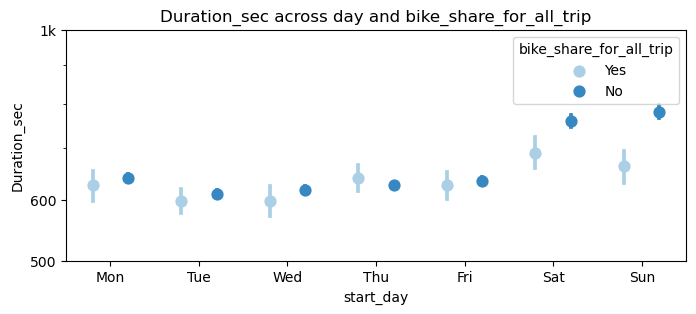

In [9]:
fig = plt.figure(figsize = [8,3])
ax = sb.pointplot(data = dataset, x = 'start_day', y = 'duration_sec', hue = 'bike_share_for_all_trip',
           palette = 'Blues', linestyles = '', dodge = 0.4)
plt.title('Duration_sec across day and bike_share_for_all_trip')
plt.ylabel('Duration_sec')
plt.yscale('log')
plt.yticks([500, 600, 1e3], [ "500", "600", '1k'])
ax.set_yticklabels([],minor = True)
plt.show();

## Member gender versus the duration
Females have marginally longer duration than. This nis evident across all days of the week. The figures below says all

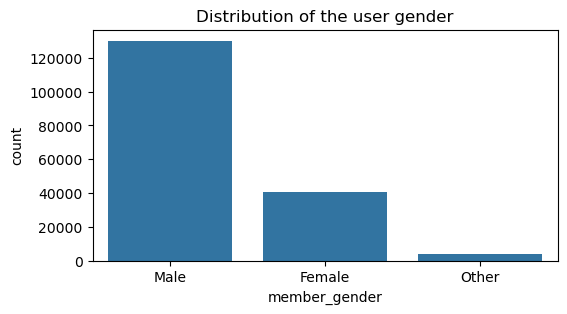

In [10]:
plt.figure(figsize=[6, 3])
plt.title("Distribution of the user gender")
sb.countplot(data = dataset, x = 'member_gender', color = default_color);


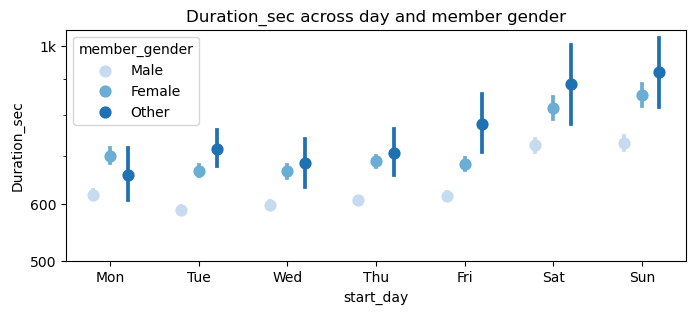

In [11]:
fig = plt.figure(figsize = [8,3])
ax = sb.pointplot(data = dataset, x = 'start_day', y = 'duration_sec', hue = 'member_gender',
           palette = 'Blues', linestyles = '', dodge = 0.4)
plt.title('Duration_sec across day and member gender')
plt.ylabel('Duration_sec')
plt.yscale('log')
plt.yticks([500, 600, 1e3], [ "500", "600", '1k'])
ax.set_yticklabels([],minor = True)
plt.show();

In [ ]:
!jupyter nbconvert Part_II_slide_deck_template.ipynb --to slides --post serve --no-input --no-prompt